In [1]:
from cltoolkit import Wordlist
from collections import Counter
from lexibank_northeuralex import Dataset as NELEX
from matplotlib import pyplot as plt
import numpy as np
from pycldf import Dataset
plt.rc('axes', labelsize=15)
from pyclts import CLTS
from scipy.stats import pearsonr
from typing import List

from eff.analysis.phi import get_sound_successions, get_phi_values 
from eff.data.dataset import CltsDataset

In [2]:
clts = CLTS()
bipa = clts.bipa

In [3]:
color_scheme = {
    0: '#929591',
    1: '#069AF3',
    2: '#FC5A50'
}

# needed for legend
colors = {
    'None': '#929591',
    'Vowel Harmony': '#069AF3',
    'Umlaut': '#FC5A50'
}

language2vh = {
    'fin' : 1,
    'olo' : 1,
    'vep' : 1,
    'ekk' : 0,
    'krl' : 1,
    'liv' : 0,
    'sma' : 2,
    'smj' : 2,
    'sme' : 2,
    'smn' : 2,
    'sms' : 2,
    'sjd' : 2,
    'mrj' : 1,
    'mhr' : 1,
    'mdf' : 1,
    'myv' : 1,
    'udm' : 0,
    'koi' : 0,
    'kpv' : 0,
    'hun' : 1,
    'kca' : 1,
    'mns' : 1,
    'sel' : 0,
    'yrk' : 0,
    'enf' : 0,
    'nio' : 1,
    'ben' : 0,
    'hin' : 0,
    'pbu' : 0,
    'pes' : 0,
    'kmr' : 0,
    'oss' : 0,
    'hye' : 0,
    'ell' : 0,
    'sqi' : 0,
    'bul' : 0,
    'hrv' : 0,
    'slv' : 0,
    'slk' : 0,
    'ces' : 0,
    'pol' : 0,
    'ukr' : 0,
    'bel' : 0,
    'rus' : 0,
    'lit' : 0,
    'lav' : 0,
    'isl' : 2,
    'nor' : 0,
    'swe' : 0,
    'dan' : 0,
    'deu' : 2,
    'nld' : 0,
    'eng' : 0,
    'gle' : 2,
    'cym' : 2,
    'bre' : 0,
    'lat' : 0,
    'fra' : 0,
    'cat' : 0,
    'spa' : 0,
    'por' : 0,
    'ita' : 0,
    'ron' : 0,
    'tur' : 1,
    'azj' : 1,
    'uzn' : 1,
    'kaz' : 1,
    'bak' : 1,
    'tat' : 1,
    'sah' : 1,
    'chv' : 1,
    'khk' : 1,
    'bua' : 1,
    'xal' : 1,
    'evn' : 1,
    'mnc' : 1,
    'gld' : 1,
    'ket' : 0,
    'ykg' : 0,
    'yux' : 0,
    'itl' : 0,
    'ckt' : 1,
    'niv' : 0,
    'ain' : 0,
    'kor' : 1,
    'jpn' : 0,
    'ale' : 0,
    'ess' : 0,
    'kal' : 0,
    'kan' : 0,
    'mal' : 0,
    'tam' : 0,
    'tel' : 1,
    'bsk' : 0,
    'kat' : 0,
    'eus' : 0,
    'abk' : 0,
    'ady' : 0,
    'ava' : 0,
    'ddo' : 0,
    'lbe' : 0,
    'lez' : 0,
    'dar' : 0,
    'che' : 0,
    'arb' : 0,
    'heb' : 0,
    'cmn' : 0
}

# only for development set
# Finnish, Turkish, Manchu, Korean, Khalkha.  
# Arabic, Ainu, Basque, Armenian, Estonian. 
lang_ids = [
            'fin', 'tur', 'mnc', 'khk', 'kor',
            'arb', 'ain', 'eus', 'hye', 'ekk'
           ]

## Data Loading Example

In [4]:
word_list = Wordlist([Dataset.from_metadata(NELEX().cldf_dir.joinpath('cldf-metadata.json'))])

print("Loaded NELEX with {} languages".format(len(word_list.languages)))

loading forms for northeuralex: 100%|██████████| 121612/121612 [00:02<00:00, 42861.01it/s]


Loaded NELEX with 107 languages


In [5]:
print(word_list.languages[0].id)
languages = [language for language in word_list.languages if language.id.split("-")[1] in lang_ids]
print([lang.name for lang in languages])

northeuralex-fin
['Finnish', 'Estonian', 'Armenian', 'Turkish', 'Khalkha Mongolian', 'Manchu', 'Hokkaido Ainu', 'Korean', 'Basque', 'Standard Arabic']


## NELEX sample

In [6]:
print("Language & Conecpt & Orthography & IPA")

for l in [0, 50, 66]:
    language = word_list.languages[l]
    # language: Language = None
    # lang_id = language.id.split('-')[1]
    # print(language.name)
    # print(language.concepts[:3])
    # print(language.forms[0].data)
    for i in range(3):
        print(
            language.name, '&',
            language.concepts[i].name, '&',
            language.forms[i].data['Value'], '&',
            language.forms[i].data['Form'], '\\\\'
        )

Language & Conecpt & Orthography & IPA
Finnish & eye & silmä & silmæ \\
Finnish & ear & korva & kɔrʋɑ \\
Finnish & nose & nenä & nɛnæ \\
German & eye & Auge & aʊ̯ɡə \\
German & ear & Ohr & oːɐ̯ \\
German & nose & Nase & naːzə \\
Kazakh & eye & көз & køz \\
Kazakh & ear & құлақ & qʉlɑq \\
Kazakh & nose & мұрын & mʉɾən \\


## Unigram Perplexity

In [7]:
def get_perplexity(gr_probs: List[float], word: List[str]):
    word_probs = [gr_probs[gr] for gr in word]
    P_seq = np.prod(word_probs)
    return 2**((-1/len(word)*np.log2(P_seq)))

def get_unigram_probs(words: List[List[str]]):
    graphemes = []
    for word in words:
        graphemes.extend(word)
    gr_counts = Counter(graphemes)
    gr_probs = {gr: count/len(graphemes) for gr, count in gr_counts.items()}
    return gr_probs

unigram_pp = {}

for language in word_list.languages:
    lang_id = language.id.split("-")[1]
    DS = CltsDataset(language)
    gr_probs = get_unigram_probs(DS.words)
    pps = [get_perplexity(gr_probs, word) for word in DS.words]
    unigram_pp[lang_id] = sum(pps)/len(pps)

In [8]:
sizes = {}
cv_ratios = {}
mean_lengths = {}
word_counts = {}
vowel_inv_sizes = {}

for language in word_list.languages:
    lang_id = language.id.split("-")[1]
    DS = CltsDataset(language)
    inventory = DS.alphabet.chars
    word_counts[lang_id] = len(DS.words)
    vowels = [grapheme for grapheme in inventory if bipa[grapheme].type in ['vowel', 'diphthong']]
    # print(lang_id, vowels)
    vowel_inv_sizes[lang_id] = len(vowels)
    consonants = [grapheme for grapheme in inventory if bipa[grapheme].type in ['consonant']]
    sizes[lang_id] = len(inventory) - 4 # pad, mask, eos, bos
    cv_ratios[lang_id] = round(len(consonants)/len(vowels), 2)
    mean_word_length = sum([len(word) for word in DS.words])/len(DS)
    mean_lengths[lang_id] = mean_word_length

# Figures

## Inventory Size
Inventory sizes derived from Northeuralex data provided via CLTS. Long and short vowels were merged (this preprocessing step is also applied to the data before being fed to the model).

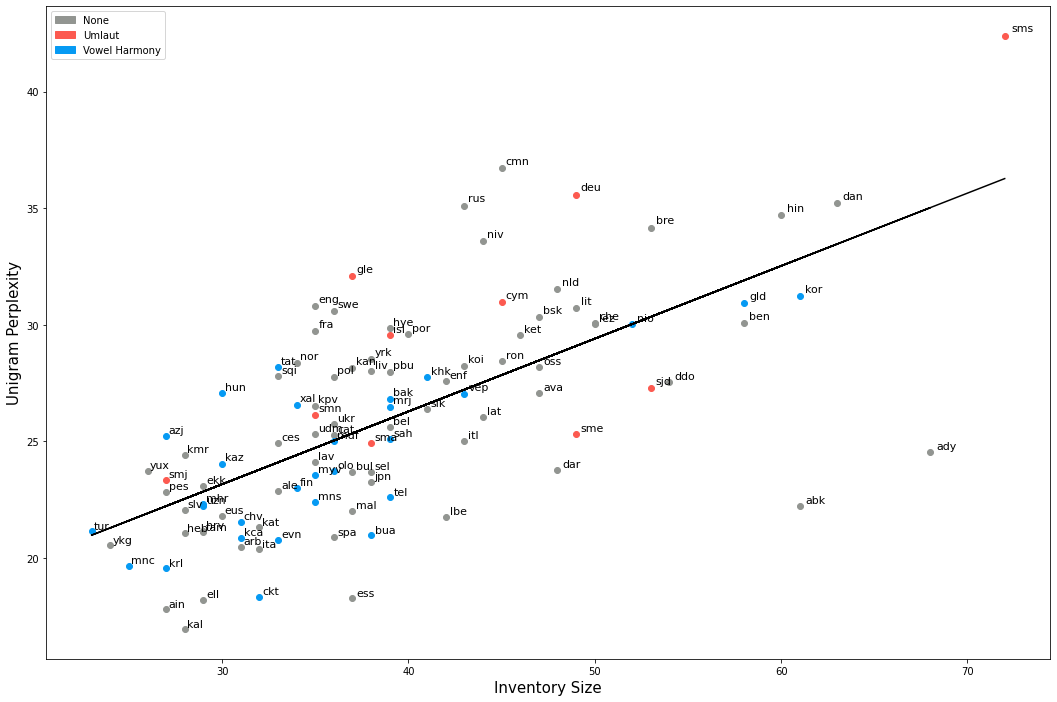

In [9]:
# plot perplexity vs. inventory size
plt.figure(figsize=(18, 12))
uni_pp_sorted = dict(sorted(unigram_pp.items(), key=lambda item: item[1])[::-1])
# langs = list(uni_pp_sorted.keys())
sizes_ = []
for x, (lang_id, pp) in enumerate(uni_pp_sorted.items()):
    size = sizes[lang_id]
    sizes_.append(size)
    color = color_scheme[language2vh[lang_id]]
    labels = ['None', 'Umlaut', 'Vowel Harmony']
    # labels = ['None', 'Vowel Harmony']
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    # color = '#929591'
    plt.scatter(size, pp, color=color, label=lang_id)
    plt.text(size*1.005, pp*1.005, lang_id, fontsize=11)
# regression line
x = np.array(sizes_)
y = np.array(list(uni_pp_sorted.values()))
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, color='black')
# plt.xticks(np.arange(len(langs)), langs, rotation=90)
plt.xlabel("Inventory Size")
plt.ylabel("Unigram Perplexity")
plt.legend(handles, labels)
plt.savefig("../img/unigram_pp_vs_inventory_size.png",
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)
plt.show()

In [10]:
# Pearson's r
x = np.array(list(sizes.values()))
y = np.array(list(unigram_pp.values()))

r, p_value = pearsonr(x, y)

print(r, p_value)

0.6681063903505884 3.799753042926988e-15


## Vowel-Consonant-Ratio

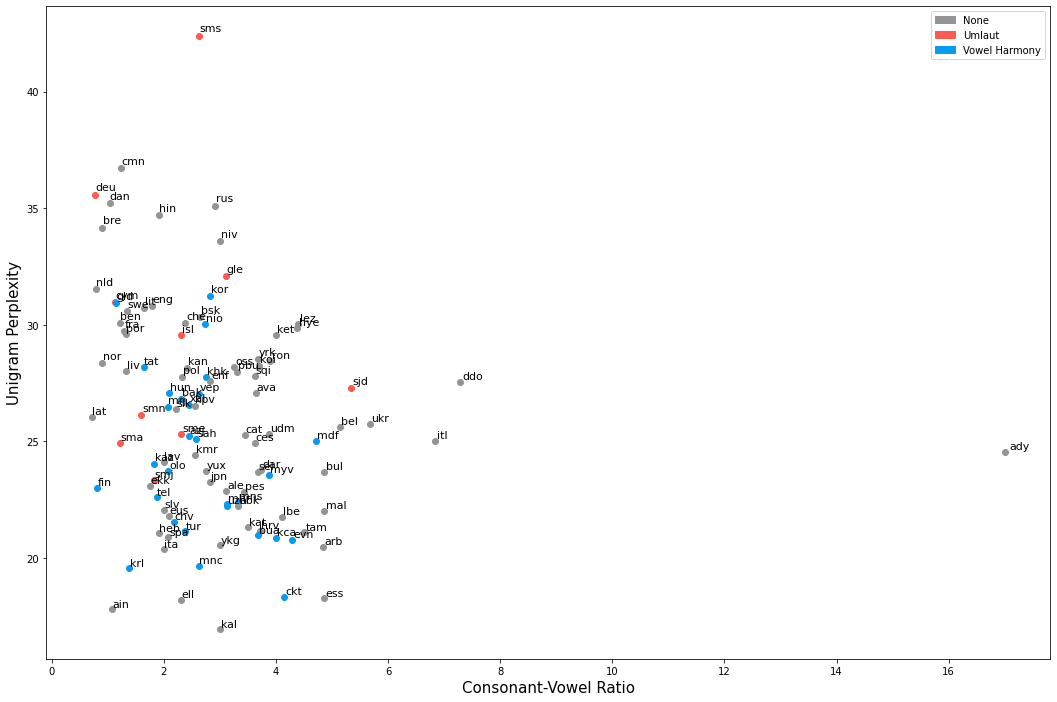

In [11]:
# plot perplexity vs. inventory size
plt.figure(figsize=(18, 12))
uni_pp_sorted = dict(sorted(unigram_pp.items(), key=lambda item: item[1])[::-1])
# langs = list(pp_sorted.keys())
for x, (lang_id, pp) in enumerate(uni_pp_sorted.items()):
    cv_ratio = cv_ratios[lang_id]
    # color = '#929591'
    color = color_scheme[language2vh[lang_id]]
    labels = ['None', 'Umlaut', 'Vowel Harmony']
    # labels = ['None', 'Vowel Harmony']
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.scatter(cv_ratio, pp, color=color, label=lang_id)
    plt.text(cv_ratio*1.005, pp*1.005, lang_id, fontsize=11)
# plt.xticks(np.arange(len(langs)), langs, rotation=90)
plt.xlabel("Consonant-Vowel Ratio")
plt.ylabel("Unigram Perplexity")
plt.legend(handles, labels)
plt.savefig("../img/unigram_pp_vs_vc_ratio.png",
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)
plt.show()


In [12]:
# Pearson's r
x = np.array(list(cv_ratios.values()))
y = np.array(list(unigram_pp.values()))

r, p_value = pearsonr(x, y)

print(r, p_value)

-0.1961865965427952 0.04284062832386516


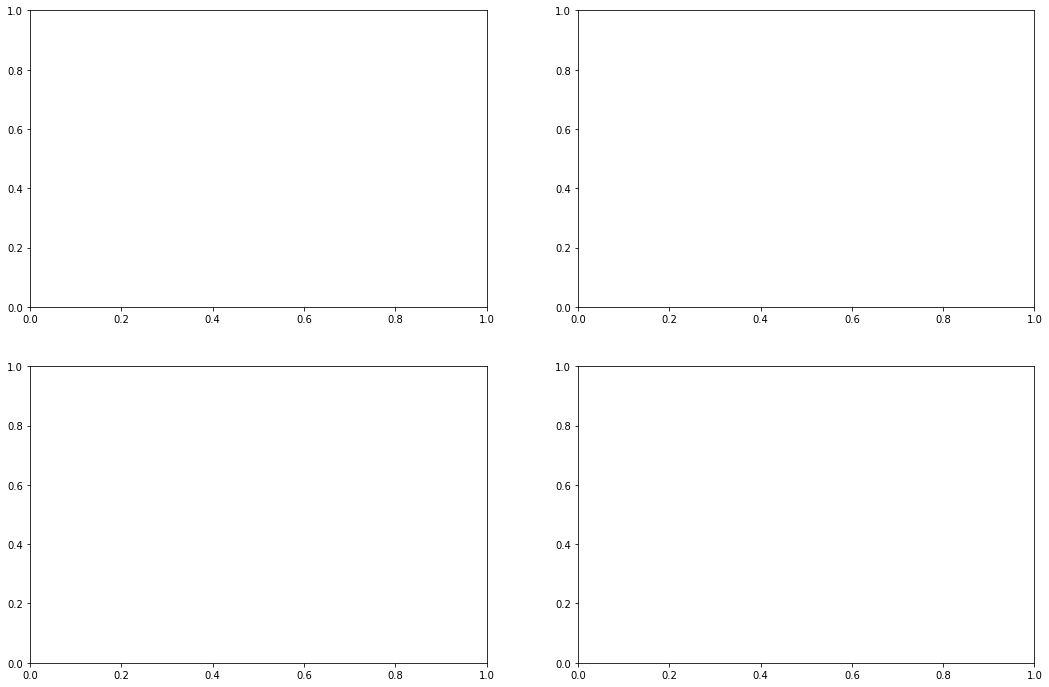

In [13]:
# all
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
ax_uni_is = axs[0,0]
ax_uni_wl = axs[0,1]
ax_nlm_is = axs[1,0]
ax_nlm_wl = axs[1,1]

## Mean Word Length

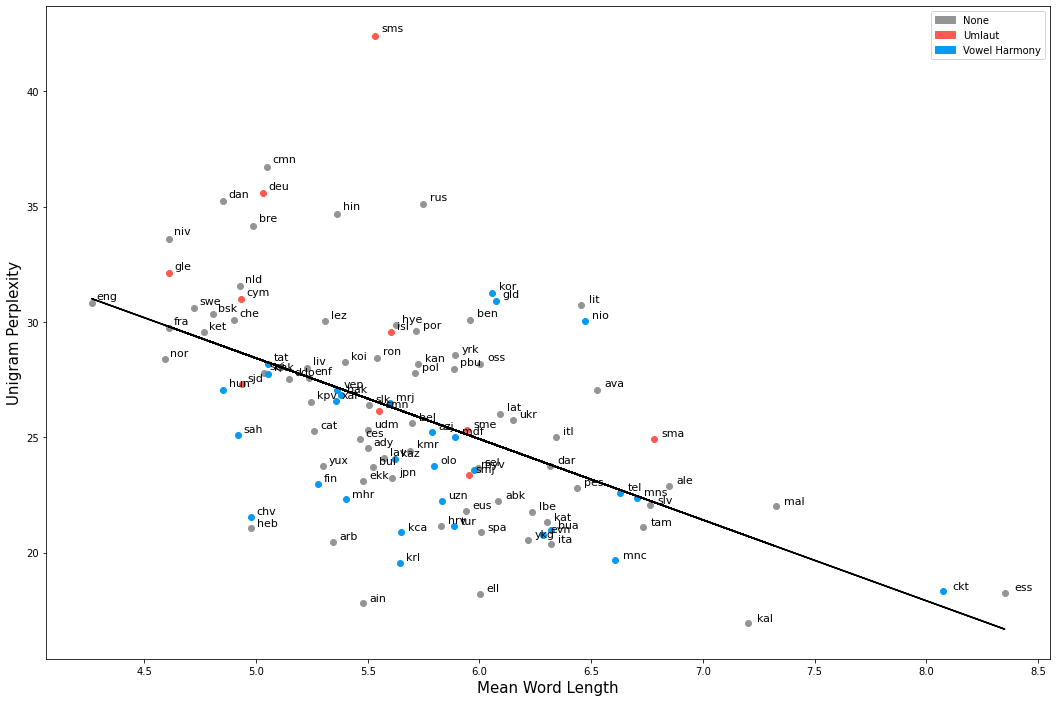

In [14]:
# plot perplexity vs. inventory size
plt.figure(figsize=(18, 12))
uni_pp_sorted = dict(sorted(unigram_pp.items(), key=lambda item: item[1])[::-1])
# langs = list(pp_sorted.keys())
mean_lengths_ = []
for x, (lang_id, pp) in enumerate(uni_pp_sorted.items()):
    mean_length = mean_lengths[lang_id]
    # color = '#929591'
    color = color_scheme[language2vh[lang_id]]
    # labels = ['None', 'Vowel Harmony']
    labels = ['None', 'Umlaut', 'Vowel Harmony']
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.scatter(mean_length, pp, color=color, label=lang_id)
    plt.text(mean_length*1.005, pp*1.005, lang_id, fontsize=11)
    mean_lengths_.append(mean_length)
# regression line
x = np.array(mean_lengths_)
y = np.array(list(uni_pp_sorted.values()))
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, color='black')
# plt.xticks(np.arange(len(langs)), langs, rotation=90)
plt.xlabel("Mean Word Length")
plt.ylabel("Unigram Perplexity")
plt.legend(handles, labels)
plt.savefig("../img/unigram_pp_vs_mean_length.png",
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)
plt.show()

In [15]:
# Pearson's r
x = np.array(list(mean_lengths.values()))
y = np.array(list(unigram_pp.values()))

r, p_value = pearsonr(x, y)

print(r, p_value)

-0.5339274118325934 3.174986730530042e-09


## Words per language

In [16]:
n_words = {language.id.split('-')[1]: len(language.forms) for language in word_list.languages}
max_words = max(n_words, key=n_words.get)
min_words = min(n_words, key=n_words.get)
med_idx = round(len(sizes)/2)
med_words = sorted(n_words.values())[med_idx]
avg_words = sum(n_words.values())/len(n_words)
print(max_words, n_words[max_words], min_words, n_words[min_words], round(avg_words, 1), med_words)

mnc 1513 itl 677 1136.6 1142


## Average Inventory Size, V-C ratio

In [17]:
sizes = {}
cv_ratios = {}
for language in word_list.languages:
    lang_id = language.id.split("-")[1]
    DS = CltsDataset(language)
    inventory = DS.alphabet.chars
    vowels = [grapheme for grapheme in inventory if bipa[grapheme].type in ['vowel', 'diphthong']]
    consonants = [grapheme for grapheme in inventory if bipa[grapheme].type in ['consonant']]
    sizes[lang_id] = len(inventory) - 4 # pad, mask, eos, bos
    cv_ratios[lang_id] = round(len(consonants)/len(vowels), 2)

In [18]:
max_size = max(sizes, key=sizes.get)
min_size = min(sizes, key=sizes.get)
avg_size = sum(sizes.values())/len(sizes)
med_idx = round(len(sizes)/2)
med_size = sorted(sizes.values())[med_idx]
print("Max inventory size: {} ({})".format(sizes[max_size], max_size))
print("Min inventory size: {} ({})".format(sizes[min_size], min_size))
print("Avg inventory size: {}".format(round(avg_size, 2)))
print("Med inventory size: {}".format(med_size))

Max inventory size: 72 (sms)
Min inventory size: 23 (tur)
Avg inventory size: 38.93
Med inventory size: 37


In [19]:
max_ratio = max(cv_ratios, key=cv_ratios.get)
min_ratio = min(cv_ratios, key=cv_ratios.get)
avg_ratio = sum(cv_ratios.values())/len(cv_ratios)
med_idx = round(len(cv_ratios)/2)
med_size = sorted(cv_ratios.values())[med_idx]
print("Max cv ratio: {} ({})".format(cv_ratios[max_ratio],max_ratio))
print("Min cv ratio: {} ({})".format(cv_ratios[min_ratio], min_ratio))
print("Avg cv ratio: {}".format(round(avg_ratio, 2)))
print("Med cv ratio: {}".format(med_size))

Max cv ratio: 17.0 (ady)
Min cv ratio: 0.71 (lat)
Avg cv ratio: 2.94
Med cv ratio: 2.64


## Language families

In [20]:
families = [language.family for language in word_list.languages]
families = Counter(families)

for family, count in families.items():
    print(family, count)

Uralic 26
Indo-European 37
Turkic 8
Mongolic 3
Tungusic 3
Yeniseian 1
Yukaghir 2
Chukotko-Kamchatkan 2
Nivkh 1
Ainu 1
Koreanic 1
Japonic 1
Eskimo-Aleut 3
Dravidian 4
Burushaski 1
Kartvelian 1
Basque 1
Abkhaz-Adyge 2
Nakh-Daghestanian 6
Afro-Asiatic 2
Sino-Tibetan 1


## NLM Perplexity

In [21]:
f = open("../result_perplexity.txt", 'r').read()

test_pp = {}

for line in f.split("\n")[:-1]:
    lang_id, pp = line.split("\t")
    test_pp[lang_id] = float(pp)

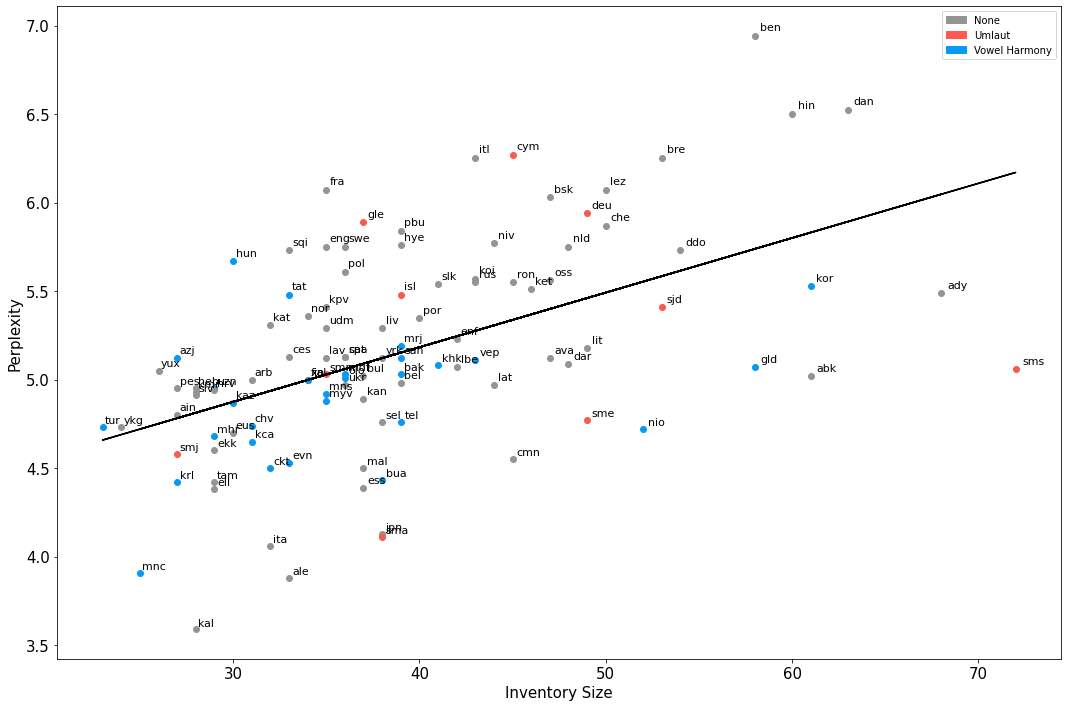

In [22]:
# plot perplexity vs. inventory size
plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.figure(figsize=(18, 12))
nlm_pp_sorted = dict(sorted(test_pp.items(), key=lambda item: item[1])[::-1])
# langs = list(nlm_pp_sorted.keys())
sizes_ = []
for x, (lang_id, pp) in enumerate(nlm_pp_sorted.items()):
    size = sizes[lang_id]
    sizes_.append(size)
    color = color_scheme[language2vh[lang_id]]
    labels = ['None', 'Umlaut', 'Vowel Harmony']
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    # color = 'b'
    plt.scatter(size, pp, color=color)
    plt.text(size*1.005, pp*1.005, lang_id, fontsize=11)
# regression line
x = np.array(sizes_)
y = np.array(list(nlm_pp_sorted.values()))
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, color='#000000')
# plt.xticks(np.arange(len(langs)), langs, rotation=90)
plt.xlabel("Inventory Size")
plt.ylabel("Perplexity")
plt.legend(handles, labels)
plt.savefig("../img/test_pp_vs_inventory_size_no_vh.png",
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)
plt.show()

In [23]:
# Pearson's r
x = np.array(list(sizes.values()))
y = np.array(list(test_pp.values()))

r, p_value = pearsonr(x, y)

print(r, p_value)

0.5182518682148227 1.0812768626248408e-08


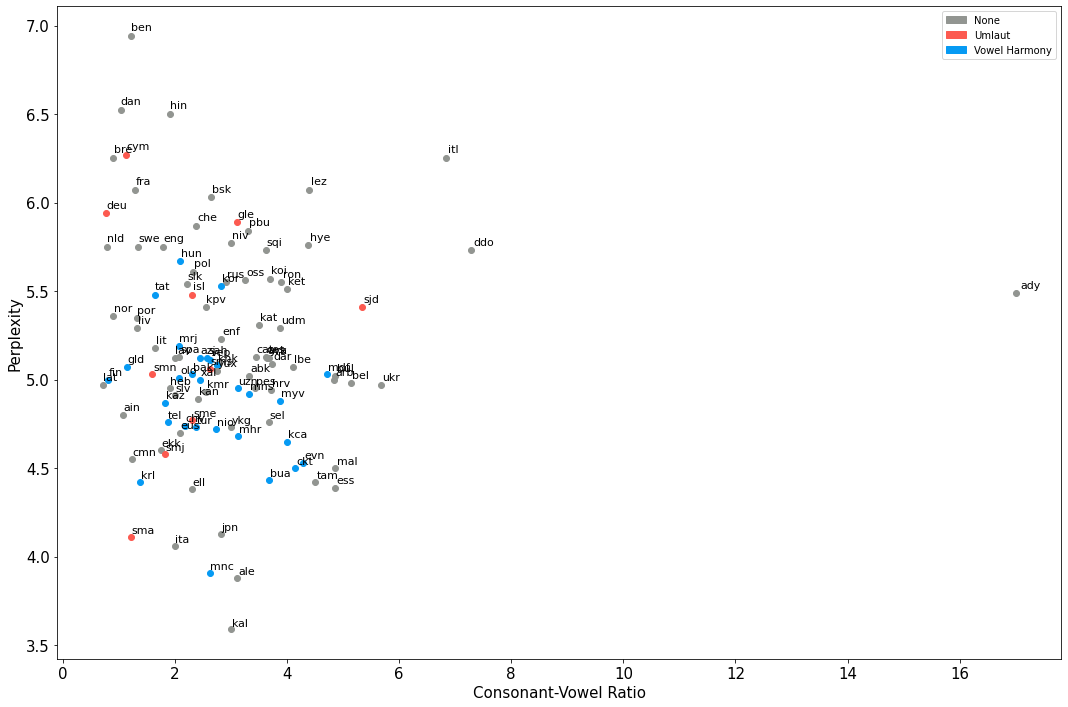

In [24]:
# plot perplexity vs. consonant-vowel ratio
plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.figure(figsize=(18, 12))
nlm_pp_sorted = dict(sorted(test_pp.items(), key=lambda item: item[1])[::-1])
# langs = list(pp_sorted.keys())
for x, (lang_id, pp) in enumerate(nlm_pp_sorted.items()):
    cv_ratio = cv_ratios[lang_id]
    # color = 'b'
    color = color_scheme[language2vh[lang_id]]
    labels = ['None', 'Umlaut', 'Vowel Harmony']
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    plt.scatter(cv_ratio, pp, color=color, label=lang_id)
    plt.text(cv_ratio*1.005, pp*1.005, lang_id, fontsize=11)
# plt.xticks(np.arange(len(langs)), langs, rotation=90)
plt.xlabel("Consonant-Vowel Ratio")
plt.ylabel("Perplexity")
plt.legend(handles, labels)
plt.savefig("../img/test_pp_vs_vc_ratio.png",
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)
plt.show()

In [25]:
# Pearson's r
x = np.array(list(cv_ratios.values()))
y = np.array(list(test_pp.values()))

r, p_value = pearsonr(x, y)

print(r, p_value)

-0.01804603864868437 0.8536273805638671


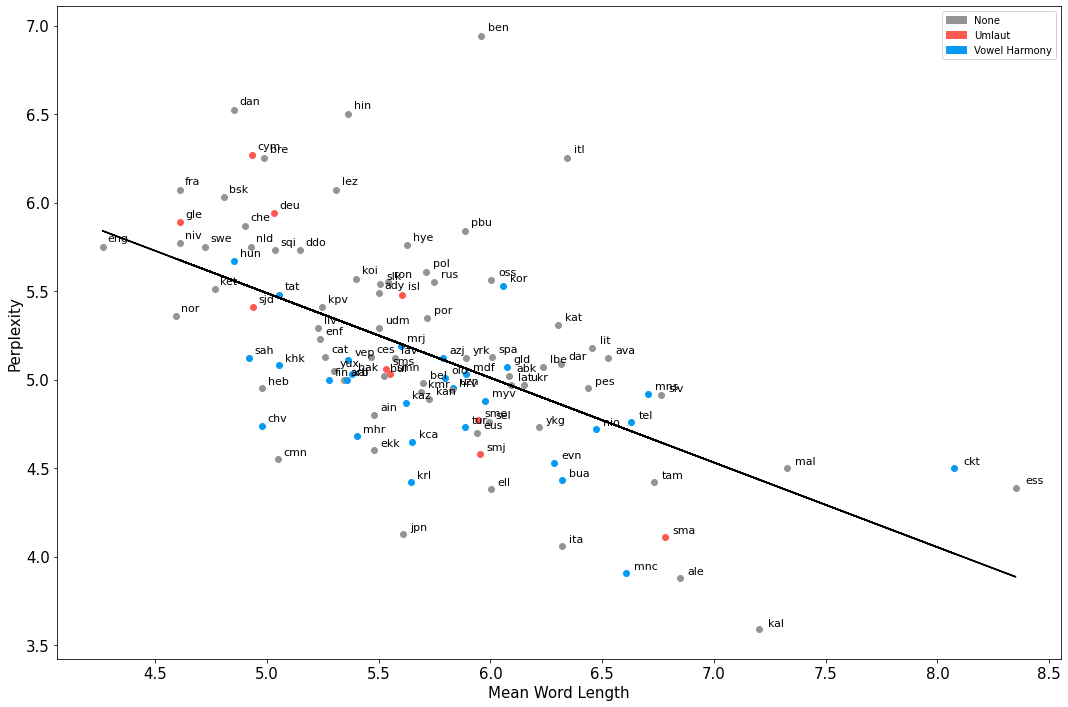

In [26]:
# plot perplexity vs. mean word length
plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.figure(figsize=(18, 12))
nlm_pp_sorted = dict(sorted(test_pp.items(), key=lambda item: item[1])[::-1])
nlm_langs = list(nlm_pp_sorted.keys())
mean_lengths_ = []
for x, (lang_id, pp) in enumerate(nlm_pp_sorted.items()):
    mean_length = mean_lengths[lang_id]
    mean_lengths_.append(mean_length)
    color = color_scheme[language2vh[lang_id]]
    labels = ['None', 'Umlaut', 'Vowel Harmony']
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    # color = 'b'
    plt.scatter(mean_length, pp, color=color)
    plt.text(mean_length*1.005, pp*1.005, lang_id, fontsize=11)
# regression line
x = np.array(mean_lengths_)
y = np.array(list(nlm_pp_sorted.values()))
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, color='#000000')
# plt.xticks(np.arange(len(langs)), langs, rotation=90)
plt.xlabel("Mean Word Length")
plt.ylabel("Perplexity")
plt.legend(handles, labels)
plt.savefig("../img/test_pp_vs_mean_length.png",
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)
plt.show()

In [27]:
# Pearson's r
x = np.array(list(mean_lengths.values()))
y = np.array(list(test_pp.values()))

r, p_value = pearsonr(x, y)

print(r, p_value)

-0.5717075409679782 1.261910194044777e-10


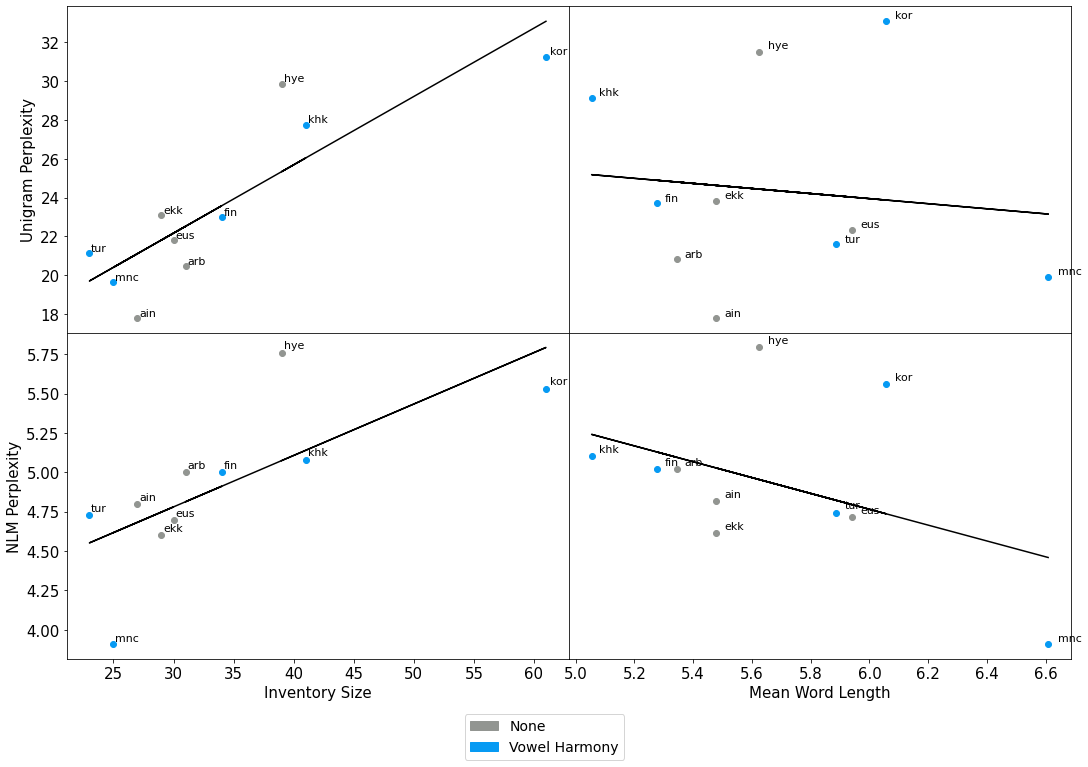

In [28]:
# all
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
# fig, axs = gs.subplots()
# ax_uni_is = axs[0,0]
# ax_uni_wl = axs[0,1]
# ax_nlm_is = axs[1,0]
# ax_nlm_wl = axs[1,1]
(ax_uni_is, ax_uni_wl), (ax_nlm_is, ax_nlm_wl) = gs.subplots()

labels = ['None', 'Vowel Harmony']
# labels = ['None', 'Umlaut', 'Vowel Harmony']

# unigram vs inventory size
sizes_ = []
for x, (lang_id, pp) in enumerate(uni_pp_sorted.items()):
    if lang_id in lang_ids:
        size = sizes[lang_id]
        sizes_.append(size)
        color = color_scheme[language2vh[lang_id]]
        # labels = ['None', 'Umlaut', 'Vowel Harmony']
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        # color = '#929591'
        ax_uni_is.scatter(size, pp, color=color, label=lang_id)
        ax_uni_is.text(size*1.005, pp*1.005, lang_id, fontsize=11)
# regression line
x = np.array(sizes_)
y = np.array(list([pp for lang_id, pp in uni_pp_sorted.items() if lang_id in lang_ids]))
m, b = np.polyfit(x, y, 1)
ax_uni_is.plot(x, m*x+b, color='black')
# plt.xticks(np.arange(len(langs)), langs, rotation=90)
# ax_uni_is.set_xlabel("Inventory Size")
ax_uni_is.set_ylabel("Unigram Perplexity")
ax_uni_is.set_xticks([])
# plt.legend(handles, labels)
# plt.savefig("../img/unigram_pp_vs_inventory_size.png")

# unigram vs mean word length
mean_lengths_ = []
for x, (lang_id, pp) in enumerate(uni_pp_sorted.items()):
    if lang_id in lang_ids:
        mean_length = mean_lengths[lang_id]
        # color = '#929591'
        color = color_scheme[language2vh[lang_id]]
        # labels = ['None', 'Umlaut', 'Vowel Harmony']
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        ax_uni_wl.scatter(mean_length, pp, color=color, label=lang_id)
        ax_uni_wl.text(mean_length*1.005, pp*1.005, lang_id, fontsize=11)
        mean_lengths_.append(mean_length)
# regression line
x = np.array(mean_lengths_)
y = np.array(list([pp for lang_id, pp in uni_pp_sorted.items() if lang_id in lang_ids]))

m, b = np.polyfit(x, y, 1)
ax_uni_wl.plot(x, m*x+b, color='black')
ax_uni_wl.set_yticks([])
# plt.xticks(np.arange(len(langs)), langs, rotation=90)
# ax_uni_wl.set_xlabel("Mean Word Length")
# ax_uni_wl.set_ylabel("Unigram Perplexity")
# plt.legend(handles, labels)
# plt.savefig("../img/unigram_pp_vs_mean_length.png")

# nlm perplexity vs inventory size
sizes_ = []
for x, (lang_id, pp) in enumerate(nlm_pp_sorted.items()):
    if lang_id in lang_ids:
        size = sizes[lang_id]
        sizes_.append(size)
        color = color_scheme[language2vh[lang_id]]
        # labels = ['None', 'Umlaut', 'Vowel Harmony']
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        # color = 'b'
        ax_nlm_is.scatter(size, pp, color=color)
        ax_nlm_is.text(size*1.005, pp*1.005, lang_id, fontsize=11)
# regression line
x = np.array(sizes_)
y = np.array(list([pp for lang_id, pp in nlm_pp_sorted.items() if lang_id in lang_ids]))
m, b = np.polyfit(x, y, 1)
ax_nlm_is.plot(x, m*x+b, color='#000000')
# plt.xticks(np.arange(len(langs)), langs, rotation=90)
ax_nlm_is.set_xlabel("Inventory Size")
ax_nlm_is.set_ylabel("NLM Perplexity")
# plt.legend(handles, labels)
# plt.savefig("../img/test_pp_vs_inventory_size_no_vh.png")

# nlm perplexity vs mean word length
mean_lengths_ = []
for x, (lang_id, pp) in enumerate(nlm_pp_sorted.items()):
    if lang_id in lang_ids:
        mean_length = mean_lengths[lang_id]
        mean_lengths_.append(mean_length)
        color = color_scheme[language2vh[lang_id]]
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        # color = 'b'
        ax_nlm_wl.scatter(mean_length, pp, color=color)
        ax_nlm_wl.text(mean_length*1.005, pp*1.005, lang_id, fontsize=11)
# regression line
x = np.array(mean_lengths_)
y = np.array(list([pp for lang_id, pp in nlm_pp_sorted.items() if lang_id in lang_ids]))
m, b = np.polyfit(x, y, 1)
ax_nlm_wl.plot(x, m*x+b, color='#000000')
# plt.xticks(np.arange(len(langs)), langs, rotation=90)
ax_nlm_wl.set_xlabel("Mean Word Length")
ax_nlm_wl.set_yticks([])
# ax_nlm_wl.set_ylabel("NLM Perplexity")
fig.legend(handles, labels, loc='lower center', prop={'size': 14})
# plt.savefig("../img/test_pp_vs_mean_length.png")

plt.savefig("../img/pp_all.png",
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)


plt.show()

# Correlations

## Correlation avg Phi/VH

In [29]:
avg_phis = {}
# vh_yn = {}

for language in word_list.languages:
    lang_id = language.id.split("-")[1]
    dataset = CltsDataset(language)
    df_ss = get_sound_successions(dataset.words, ['vowel', 'diphthong'])
    df_phi = get_phi_values(df_ss)
    avg_phi = df_phi.sum().sum()/df_phi.size
    avg_phis[lang_id] = avg_phi
    # vh_yn[lang_id] = language2vh[lang_id]

In [30]:
# Pearson's r
x, y = [], []
for lang_id in avg_phis:
    x.append(avg_phis[lang_id])
    y.append(language2vh[lang_id])

x = np.array(x)
y = [1.0 if yn == 2.0 else yn for yn in y]
y = np.array(y)

r, p_value = pearsonr(x, y)

print(r, p_value)

0.36854227702577186 9.388907296760571e-05


## Correlating avg Perplexity/VH

In [31]:
x = np.array(list(test_pp.values()))
r, p_value = pearsonr(x, y)

print(r, p_value)

-0.20499691341842588 0.034162533938220496


## Correlating avg Perplexity/avg Phi

In [32]:
x, y = [], []
for lang_id in avg_phis:
    x.append(avg_phis[lang_id])
y = np.array(list(test_pp.values()))
r, p_value = pearsonr(x, y)

print(r, p_value)

-0.19697942046018424 0.04199105840122285


## Correlating Vowel Inventory/Phi

In [33]:
x, y = [], []
for lang_id in avg_phis:
    x.append(avg_phis[lang_id])
y = np.array(list(vowel_inv_sizes.values()))
r, p_value = pearsonr(x, y)

print(r, p_value)

-0.4287824808196593 4.0681907384154836e-06


## Perplexity/Number of items

In [34]:
x = np.array(list(word_counts.values()))
y = np.array(list(test_pp.values()))

r, p_value = pearsonr(x, y)

print(r, p_value)

-0.11170537124252486 0.2519992901917427


## Perplexity/Vowel inventory size

In [35]:
x = np.array(list(vowel_inv_sizes.values()))
y = np.array(list(test_pp.values()))

r, p_value = pearsonr(x, y)

print(r, p_value)

0.4132134988089981 9.713177730093685e-06


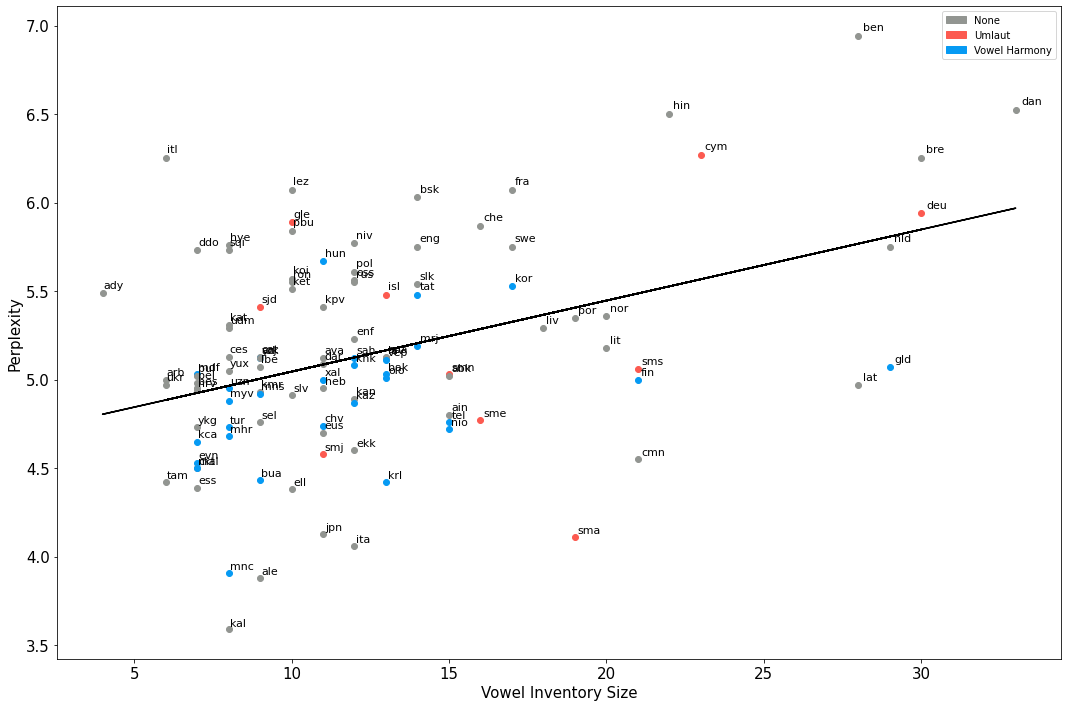

In [36]:
# Figure
# plot perplexity vs. vowel inventory size
plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.figure(figsize=(18, 12))
pp_sorted = dict(sorted(test_pp.items(), key=lambda item: item[1])[::-1])
langs = list(pp_sorted.keys())
vowel_inv_sizes_ = []
for x, (lang_id, pp) in enumerate(pp_sorted.items()):
    vowel_inv_size = vowel_inv_sizes[lang_id]
    vowel_inv_sizes_.append(vowel_inv_size)
    color = color_scheme[language2vh[lang_id]]
    labels = ['None', 'Umlaut', 'Vowel Harmony']
    handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
    # color = 'b'
    plt.scatter(vowel_inv_size, pp, color=color)
    plt.text(vowel_inv_size*1.005, pp*1.005, lang_id, fontsize=11)
# regression line
x = np.array(vowel_inv_sizes_)
y = np.array(list(pp_sorted.values()))
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, color='#000000')
# plt.xticks(np.arange(len(langs)), langs, rotation=90)
plt.xlabel("Vowel Inventory Size")
plt.ylabel("Perplexity")
plt.legend(handles, labels)
plt.savefig("../img/test_pp_vs_vowel_inv_size.png",
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)
plt.show()

## Inventory Size/Word Length

In [37]:
x = np.array(list(mean_lengths.values()))
y = np.array(list(sizes.values()))

r, p_value = pearsonr(x, y)

print(r, p_value)

-0.16057359091063145 0.09849038141404778


## Avg Perplexity VH, umlaut, None

In [38]:
from collections import defaultdict

avg_pp = defaultdict(lambda: defaultdict(lambda: []))
for lang_id, pp in test_pp.items():
    vh_yn = language2vh[lang_id]
    avg_pp[vh_yn]['data'].append(pp)

for vh_yn in avg_pp:
    data = avg_pp[vh_yn]['data']
    avg_pp[vh_yn]['mean'] = np.mean(data)
    avg_pp[vh_yn]['var'] = np.var(data)
    avg_pp[vh_yn]['std'] = np.std(data)

    print(vh_yn, avg_pp[vh_yn]['std'], avg_pp[vh_yn]['var'], avg_pp[vh_yn]['mean'])

1 0.35371276899324744 0.12511272294887044 4.901034482758621
0 0.6233469488857077 0.3885614186851212 5.240588235294118
2 0.637796205695832 0.4067839999999999 5.2540000000000004


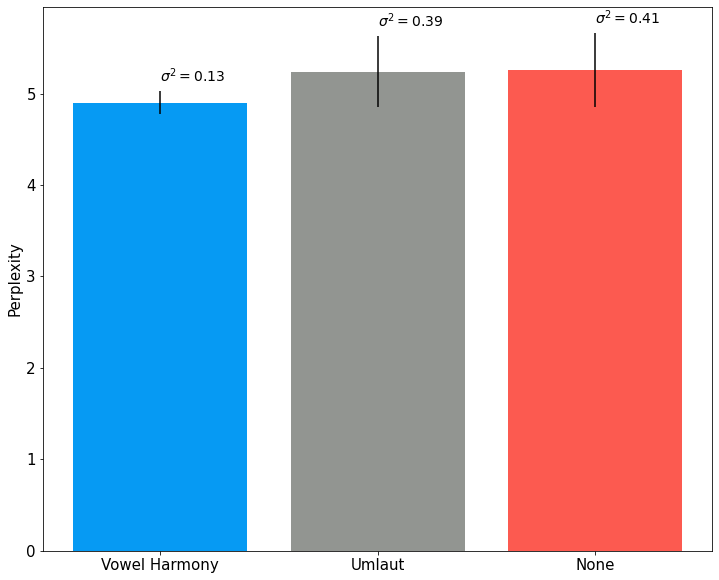

In [39]:
plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
avg_pp = dict(sorted(avg_pp.items(), key=lambda item: item[1]['mean']))
plt.figure(figsize=(12,10))
for x, vh_yn in enumerate(avg_pp):
    avg = avg_pp[vh_yn]['mean']
    var = avg_pp[vh_yn]['var']
    color = color_scheme[vh_yn]
    plt.bar(x, avg, yerr=var,  color=color)
    plt.text(x, avg+var+0.1, r"$\sigma^2 = $" + str(round(var,2)), fontsize=14)
plt.xticks(range(3), ['Vowel Harmony', 'Umlaut', 'None'])
plt.ylabel("Perplexity")
plt.savefig("../img/average_test_pp_per_type.png",
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)
plt.show()

In [40]:
# test for significance
from scipy.stats import mannwhitneyu
print("VH Languages:\t\t", len(avg_pp[1]['data']))
print("Umlaut Languages:\t", len(avg_pp[2]['data']))
print("Other Languages:\t", len(avg_pp[0]['data']))
print("Man-Whitney-U tests:")
print("Other/VH")
F_value, p_value = mannwhitneyu(avg_pp[0]['data'], avg_pp[1]['data'])
print(F_value, p_value)
print("Other/Umlaut")
F_value, p_value = mannwhitneyu(avg_pp[0]['data'], avg_pp[2]['data'])
print(F_value, p_value)
print("VH/Umlaut")
F_value, p_value = mannwhitneyu(avg_pp[1]['data'], avg_pp[2]['data'])
print(F_value, p_value)
print("VH+Umlaut/Other")
vh_pps = avg_pp[1]['data']
umlaut_pps = avg_pp[2]['data']
vh_umlaut_pps = vh_pps + umlaut_pps
F_value, p_value = mannwhitneyu(vh_umlaut_pps, avg_pp[0]['data'])
print(F_value, p_value)


VH Languages:		 29
Umlaut Languages:	 10
Other Languages:	 68
Man-Whitney-U tests:
Other/VH
1367.5 0.002675527373897848
Other/Umlaut
331.5 0.90481330469739
VH/Umlaut
94.5 0.10767346780133408
VH+Umlaut/Other
953.0 0.015889848531681388


## Phi values in appropriate color scheme

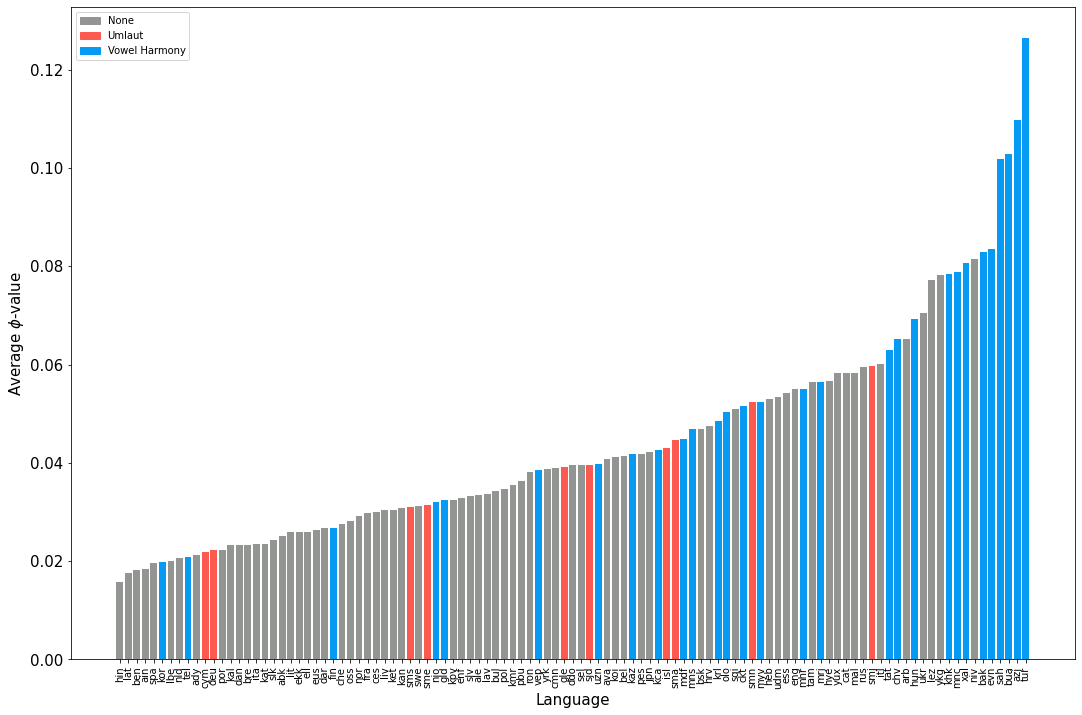

In [41]:
from eff.util import constants

plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=10)
plt.figure(figsize=(18, 12))
avg_phis = dict(sorted(avg_phis.items(), key=lambda item: item[1]))
# languages = list(avg_phis.keys())
for x, (lang, phi_vowel) in enumerate(avg_phis.items()):
    color = color_scheme[language2vh[lang]]
    labels = ['None', 'Umlaut', 'Vowel Harmony']
    handles = [plt.Rectangle((0,0),1,1, color=constants.colors[label]) for label in labels]
    plt.bar(x, phi_vowel, color=color)
plt.xticks(range(len(avg_phis)), list(avg_phis.keys()), rotation=90)
plt.legend(handles, labels)
plt.ylabel(r"Average $\phi$-value")
plt.xlabel("Language")
plt.savefig("../img/results_phi.png",
            bbox_inches='tight',
            pad_inches=0,
            format='png',
            dpi=300)
plt.show()